# Accuracy and performance evaluation of SpaCy, Stanford NER and NLTK NER Chunker

## Initialization

### Prerequisites

 - Stanford Named Entity Recognizer from CoreNLP: https://nlp.stanford.edu/software/CRF-NER.html#Download
 - SpaCy: https://spacy.io/usage/

NLTK preprequisites:

In [1]:
import nltk
nltk.download("punkt")
nltk.download("words")
nltk.download("averaged_perceptron_tagger")
nltk.download("maxent_ne_chunker")

[nltk_data] Downloading package punkt to
[nltk_data]     /home/sys_avctests/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /home/sys_avctests/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sys_avctests/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/sys_avctests/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


True

### Load taggers

In [2]:
from main import make_tagger

stub_ner = make_tagger('stub')
corenlp_ner = make_tagger('corenlp')
spacy_ner = make_tagger('spacy')
nltkchunker_ner = make_tagger('nltkchunker')

We need to change SpaCy tokenizer settings so that it matches ConLL tokens

In [3]:
import spacy

_prefixes = ['\s+']
_suffixes = ['\s+']
_infixes = ['\s+']

spacy_ner.nlp.tokenizer.infix_finditer = spacy.util.compile_infix_regex(_infixes).finditer
spacy_ner.nlp.tokenizer.prefix_search = spacy.util.compile_prefix_regex(_prefixes).search
spacy_ner.nlp.tokenizer.suffix_search = spacy.util.compile_suffix_regex(_suffixes).search

special_case = [{spacy.symbols.ORTH: u'cannot', spacy.symbols.LEMMA: u'cannot', spacy.symbols.POS: u'VERB'}]
spacy_ner.nlp.tokenizer.add_special_case(u'cannot', special_case)

## Accuracy evaluation

We evaluate accuracy using F1 score on [CoNLL-2003](https://www.clips.uantwerpen.be/conll2003/ner/) dataset.

In [4]:
def load_conll(conll_path):
    with open(conll_path, 'r') as conll_file:
        conll_data = conll_file.read()
        entries = [entry for entry in conll_data.split('\n\n') if entry]
        
        sentences = []
        tags = []
        for entry in entries:    
            lines = entry.split('\n')
            sentence = []
            sentence_tags = []
            for l in lines:
                columns = l.split(' ')
                word = columns[0]
                tag = columns[3].split('-')[-1]
                
                if word == '-DOCSTART-':
                    continue
                
                sentence.append(word)
                sentence_tags.append(tag)
            
            if not sentence:
                continue

            sentences.append(sentence)
            tags.append(sentence_tags)
            
        return sentences, tags

In [5]:
sentences, tags = load_conll('data/conll2003/eng.testa')

In [26]:
from sklearn.metrics import f1_score
import time

def evaluate_nlp(nlp, sentences, tags, print_every=10, use_first_n=None):
    y_true = []
    y_pred = []
    
    i = 0
    if use_first_n is None:
        use_first_n = len(sentences)
    total = use_first_n
    last = 0
    
    total_time = 0
    for s, t in zip(sentences[:use_first_n], tags[:use_first_n]):
        progress = int(i/total*100)
        i+=1
        if progress % print_every == 0 and progress > last:
            print('{}%'.format(progress))
            last = progress
        
        sentence = ' '.join(s)
        
        begin_time = time.perf_counter()
        
        pred = nlp.predict(sentence)
        
        end_time = time.perf_counter()
        total_time += end_time - begin_time
        
        tokens = [w for w, t in pred]
        tags_pred = [t for w, t in pred]        
        if len(tokens) != len(s):
            print(sentence)
            print('ERROR: Tokens do not match')
            print('Expected:')
            print(s)
            print('Actual:')
            print(tokens)

        y_true += t
        y_pred += tags_pred
    return f1_score(y_true, y_pred, average='weighted'), total_time

In [7]:
use_first_n = None

In [27]:
stub_score, stub_total_time = evaluate_nlp(stub_ner, sentences, tags, use_first_n=use_first_n)

10%
20%
30%
40%
50%
60%
70%
80%
90%


/home/sys_avctests/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [28]:
spacy_score, spacy_total_time = evaluate_nlp(spacy_ner, sentences, tags, use_first_n=use_first_n)

10%
20%
30%
40%
50%
60%
70%
80%
90%


In [29]:
nltk_score, nltk_total_time = evaluate_nlp(nltkchunker_ner, sentences, tags, use_first_n=use_first_n)

10%
20%
30%
40%
50%
60%
70%
80%
90%


In [11]:
corenlp_score, corenlp_total_time = evaluate_nlp(corenlp_ner, sentences, tags, print_every=5, use_first_n=use_first_n)

5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
55%
60%
65%
70%
75%
80%
85%
90%
95%


In [30]:
print('Stub    F1: {}\tTime: {} s'.format(stub_score, stub_total_time))
print('SpaCy   F1: {}\tTime: {} s'.format(spacy_score, spacy_total_time))
print('NLTK    F1: {}\tTime: {} s'.format(nltk_score, nltk_total_time))
print('CoreNLP F1: {}\tTime: {} s'.format(corenlp_score, corenlp_total_time))

Stub    F1: 0.7564088755507238	Time: 0.007582192542031407 s
SpaCy   F1: 0.8563504398999212	Time: 12.994770019082353 s
NLTK    F1: 0.8843175698887001	Time: 9.864065591013059 s
CoreNLP F1: 0.9863696253399017	Time: 978.02251217899948 s


## Performance evaluation

We evaluate performance on a sample from [Customer Support on Twitter](https://www.kaggle.com/thoughtvector/customer-support-on-twitter)

In [13]:
import pandas as pd
%matplotlib inline

In [14]:
#twcs = pd.read_csv('data/twcs/twcs.csv')
twcs = pd.read_csv('data/twcs/sample.csv')

In [15]:
twcs_inbound = twcs[twcs['inbound'] == True]

In [16]:
def evaluate_performance(nlp, msgs):
    perf = pd.DataFrame(columns=['length', 'time'])
    for sentence in msgs:
        begin_time = time.perf_counter()
        
        pred = nlp.predict(sentence)
        
        end_time = time.perf_counter()
        elapsed_time = end_time - begin_time
        
        perf = perf.append({'length': len(sentence), 'time' : elapsed_time}, ignore_index=True)

    return perf

In [17]:
nltk_perf = evaluate_performance(nltkchunker_ner, twcs_inbound['text'])

In [18]:
nltk_perf.describe()

,length,time
count,49.000000,49.000000
mean,106.142857,0.004465
std,35.308757,0.001540
min,32.000000,0.001293
25%,79.000000,0.003236
50%,108.000000,0.004787
75%,137.000000,0.005552
max,170.000000,0.007685


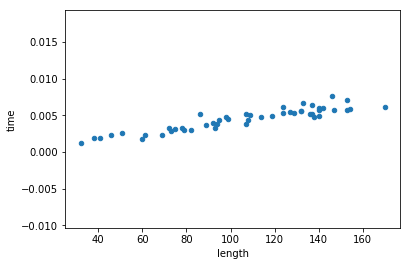

In [19]:
nltk_perf.plot(y='time', x='length', kind='scatter')

In [20]:
spacy_perf = evaluate_performance(spacy_ner, twcs_inbound['text'])

In [21]:
spacy_perf.describe()

,length,time
count,49.000000,49.000000
mean,106.142857,0.004426
std,35.308757,0.000525
min,32.000000,0.003433
25%,79.000000,0.004107
50%,108.000000,0.004459
75%,137.000000,0.004752
max,170.000000,0.006527


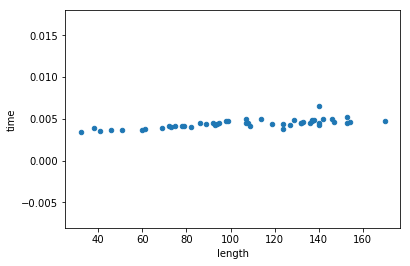

In [22]:
spacy_perf.plot(y='time', x='length', kind='scatter')

In [23]:
corenlp_perf = evaluate_performance(corenlp_ner, twcs_inbound['text'])

In [24]:
corenlp_perf.describe()

,length,time
count,49.000000,49.000000
mean,106.142857,1.267256
std,35.308757,0.049076
min,32.000000,1.187708
25%,79.000000,1.219221
50%,108.000000,1.266668
75%,137.000000,1.309793
max,170.000000,1.358970


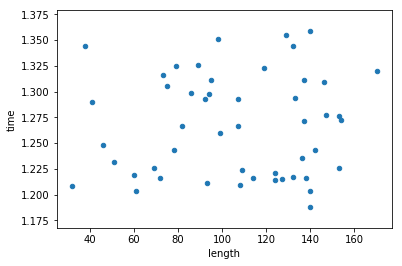

In [25]:
corenlp_perf.plot(y='time', x='length', kind='scatter')